c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`inp

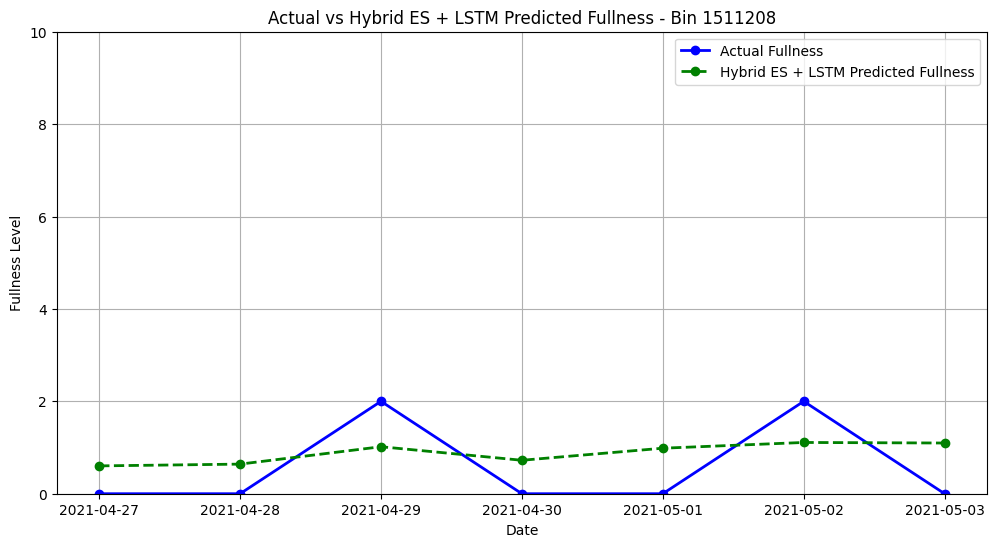

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`inp

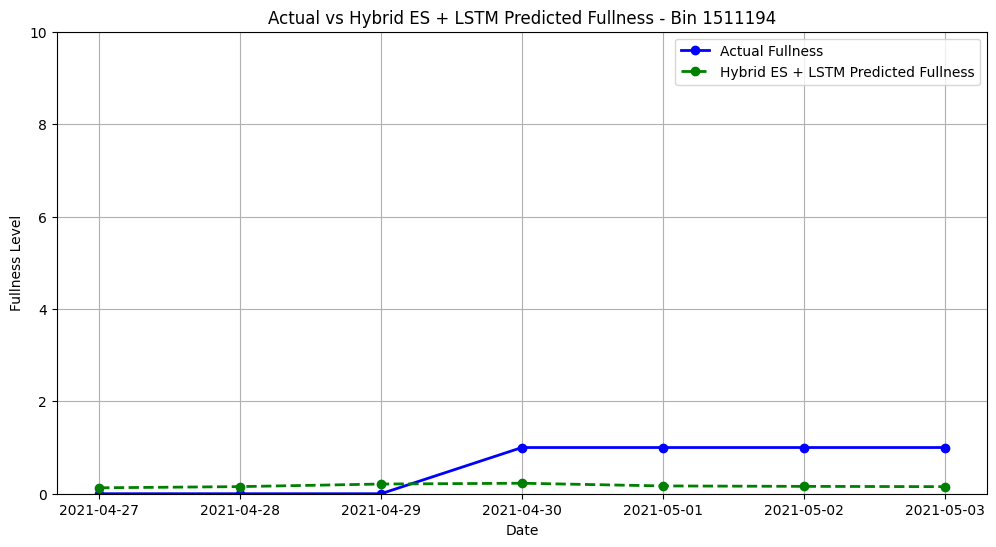

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`inp

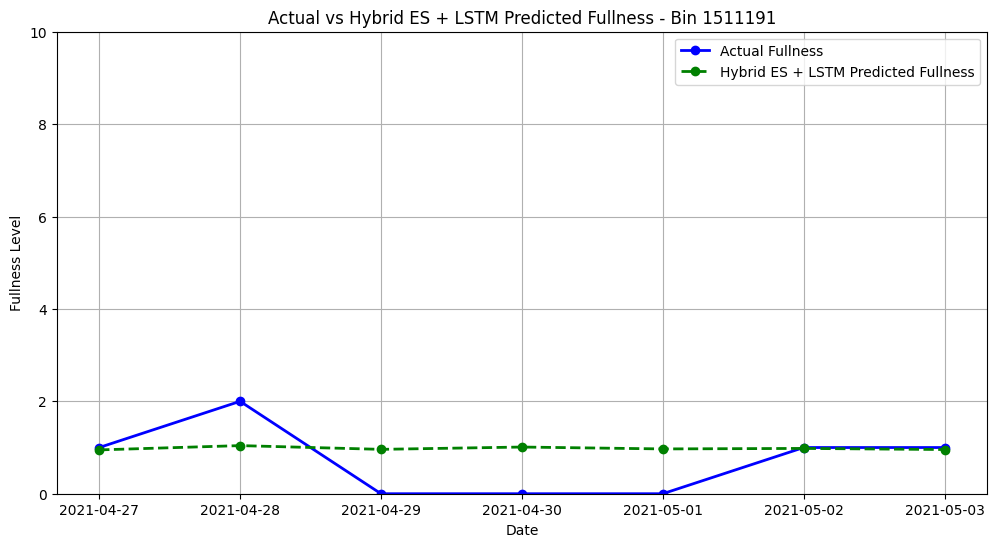

         Hybrid ES + LSTM RMSE
Bin ID                        
1511208               0.864502
1511194               0.632135
1511191               0.737493


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load resampled dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
bins_to_forecast = [1511208, 1511194, 1511191]
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to a specific date
train_data = df[df['timestamp'] <= "2021-04-26"]

# Prepare LSTM data
def prepare_data(series, time_steps=10):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i : i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)

results_es_lstm = {}

for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')
    bin_train.set_index('timestamp', inplace=True)

    # Exponential Smoothing
    es_model = ExponentialSmoothing(bin_train['Fullness'], trend='add', seasonal='add', seasonal_periods=7)
    es_fit = es_model.fit()
    es_forecast = es_fit.forecast(7)

    # Prepare LSTM data
    scaler = MinMaxScaler()
    fullness_train = scaler.fit_transform(bin_train[['Fullness']])

    time_steps = 10
    X_train, y_train = prepare_data(fullness_train, time_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build and train LSTM model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Predict next 7 days
    predictions = []
    last_sequence = fullness_train[-time_steps:].reshape(1, time_steps, 1)
    for _ in range(7):
        pred = model.predict(last_sequence, verbose=0)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    hybrid_forecast = (es_forecast.values.reshape(-1, 1) + predictions) / 2

    # Date alignment
    last_actual_date = bin_train.index[-1]
    prediction_dates = pd.date_range(start=last_actual_date + pd.Timedelta(days=1), periods=7, freq='D')

    # Resample actual data for proper alignment
    bin_full = df[df['Bin ID'] == bin_id].sort_values(by='timestamp').set_index('timestamp')
    daily_actual = bin_full['Fullness'].resample('D').last().reindex(prediction_dates).fillna(method='ffill').fillna(method='bfill')

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(prediction_dates, daily_actual.values, 'bo-', label="Actual Fullness", linewidth=2)
    plt.plot(prediction_dates, hybrid_forecast, 'go--', label="Hybrid ES + LSTM Predicted Fullness", linewidth=2)
    plt.ylim(0, 10)
    plt.title(f"Actual vs Hybrid ES + LSTM Predicted Fullness - Bin {bin_id}")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(daily_actual.values.reshape(-1, 1), hybrid_forecast))
    results_es_lstm[bin_id] = rmse

# Print RMSE values
rmse_df = pd.DataFrame.from_dict(results_es_lstm, orient='index', columns=['Hybrid ES + LSTM RMSE'])
rmse_df.index.name = "Bin ID"
print(rmse_df)


c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

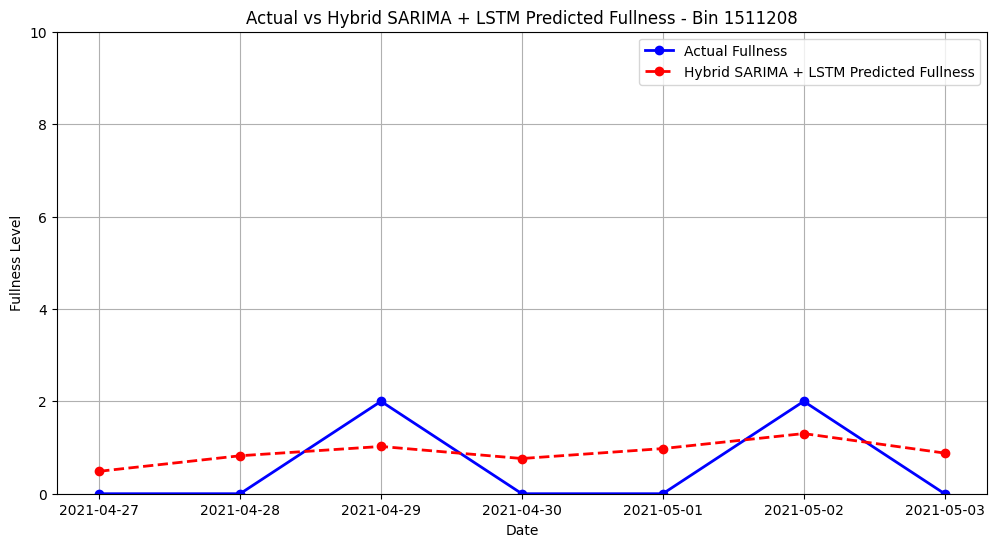

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

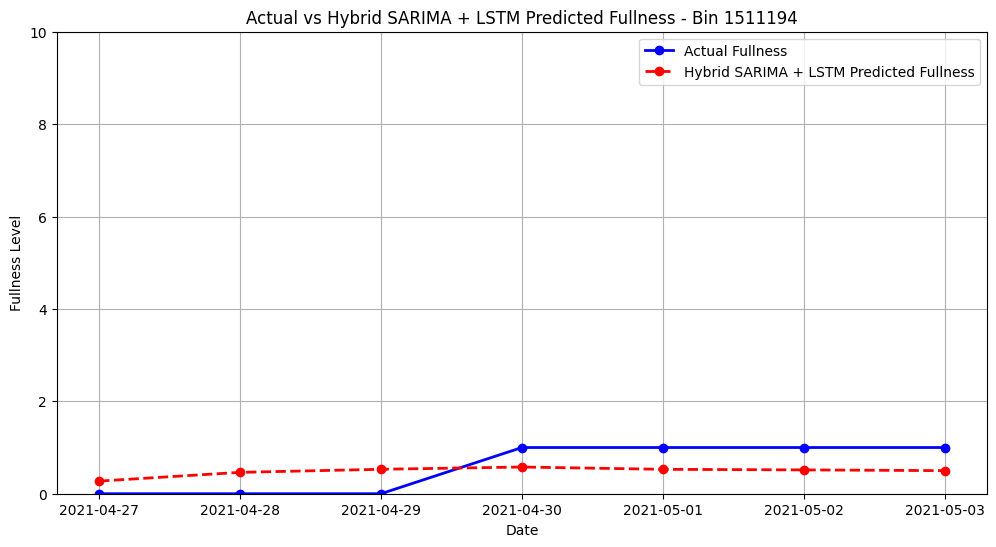

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

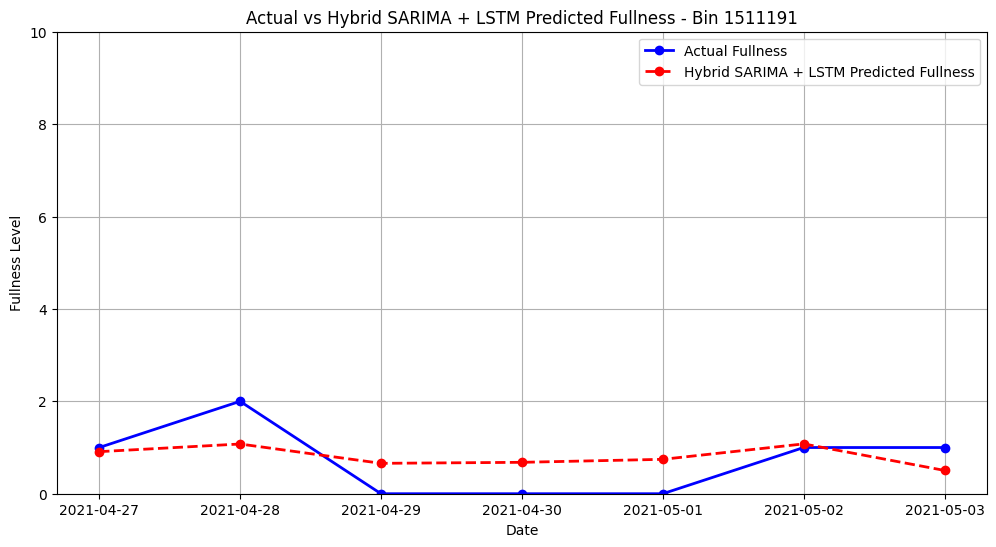

         Hybrid SARIMA + LSTM RMSE
Bin ID                            
1511208                   0.816163
1511194                   0.455803
1511191                   0.605158


In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

results_sarima_lstm = {}

for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')
    bin_train.set_index('timestamp', inplace=True)

    # Fit SARIMA model
    sarima_model = SARIMAX(bin_train['Fullness'], order=(1,1,1), seasonal_order=(1,1,1,7))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fit.forecast(steps=7)

    # Prepare LSTM predictions
    scaler = MinMaxScaler()
    fullness_train = scaler.fit_transform(bin_train[['Fullness']])

    X_train, y_train = prepare_data(fullness_train, time_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    predictions = []
    last_sequence = fullness_train[-time_steps:].reshape(1, time_steps, 1)
    for _ in range(7):
        pred = model.predict(last_sequence, verbose=0)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    hybrid_forecast = (sarima_forecast.values.reshape(-1, 1) + predictions) / 2

    # Date alignment
    last_actual_date = bin_train.index[-1]
    prediction_dates = pd.date_range(start=last_actual_date + pd.Timedelta(days=1), periods=7, freq='D')

    bin_full = df[df['Bin ID'] == bin_id].sort_values(by='timestamp').set_index('timestamp')
    daily_actual = bin_full['Fullness'].resample('D').last().reindex(prediction_dates).fillna(method='ffill').fillna(method='bfill')

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(prediction_dates, daily_actual.values, 'bo-', label="Actual Fullness", linewidth=2)
    plt.plot(prediction_dates, hybrid_forecast, 'ro--', label="Hybrid SARIMA + LSTM Predicted Fullness", linewidth=2)
    plt.ylim(0, 10)
    plt.title(f"Actual vs Hybrid SARIMA + LSTM Predicted Fullness - Bin {bin_id}")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(daily_actual.values.reshape(-1, 1), hybrid_forecast))
    results_sarima_lstm[bin_id] = rmse

# Print RMSE values
rmse_df = pd.DataFrame.from_dict(results_sarima_lstm, orient='index', columns=['Hybrid SARIMA + LSTM RMSE'])
rmse_df.index.name = "Bin ID"
print(rmse_df)
